In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import mplhep as hep
import os

In [3]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from  sklearn.preprocessing import label_binarize
import shap

In [4]:
os.environ["OMP_NUM_THREADS"] = "20"
os.environ["MKL_NUM_THREADS"] = "20"
plots_dir = "plots"

In [5]:
# File paths for signal and background root files: 
photon_PU0 = "/data/data.polcms/cms/debnath/CMSSW_14_0_0_pre1/src/shower_shape_studies/photons_0PU_bc_stc_hadd.root"
photon_PU200_gen = "/data/data.polcms/cms/debnath/CMSSW_14_0_0_pre1/src/shower_shape_studies/gen_filtered.h5"
photon_PU200_cl3d = "/data/data.polcms/cms/debnath/CMSSW_14_0_0_pre1/src/shower_shape_studies/cl3d_filtered.h5"
neutrino_PU200_cl3d = "/data/data.polcms/cms/debnath/CMSSW_14_0_0_pre1/src/shower_shape_studies/cl3d_filtered_neutrino.h5"
neutrino_PU200_gen = "/data/data.polcms/cms/debnath/CMSSW_14_0_0_pre1/src/shower_shape_studies/gen_filtered_neutrino.h5"

In [6]:
signal_file = uproot.open(photon_PU0)
signal_folder = "FloatingpointMixedbcstcrealsig4DummyHistomaxxydr015GenmatchGenclustersntuple"
#bg_folder = "l1tHGCalTriggerNtuplizer"
tree_name = "HGCalTriggerNtuple"
signal_tree_path = f"{signal_folder}/{tree_name}"

# Access the signal tree in ROOT (uproot)
signal_tree = signal_file[signal_tree_path]

In [7]:
def delta_r(eta1, phi1, eta2, phi2):
    delta_eta = eta1 - eta2
    delta_phi = np.abs(phi1 - phi2)
    delta_phi = np.where(delta_phi > np.pi, 2 * np.pi - delta_phi, delta_phi)  # Adjust phi to be within [-pi, pi]
    return np.sqrt(delta_eta**2 + delta_phi**2)

In [8]:
def filter_by_delta_r(df, delta_r_threshold=0.05):
    """Filter DataFrame to keep only the highest-energy match per event within the delta R threshold."""
    required_columns = ['cl3d_eta', 'cl3d_phi', 'genpart_exeta', 'genpart_exphi', 'cl3d_energy', 'event']

    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"DataFrame must contain the following columns: {required_columns}")

    df = df.copy()  # Avoid modifying original DataFrame
    # Filter to keep only clusters with cl3d_energy > 0
    df = df[df['cl3d_ienergy'] > 0]
    # Compute delta_r
    df['delta_r'] = delta_r(df['cl3d_eta'], df['cl3d_phi'], df['genpart_exeta'], df['genpart_exphi'])
    # Filter based on delta_r threshold
    df_filtered = df[df['delta_r'] < delta_r_threshold]
    # Sort by event_id, cl3d_energy (descending), delta_r (ascending)
    df_sorted = df_filtered.sort_values(by=['event', 'cl3d_energy', 'delta_r'], ascending=[True, False, True])
    # Keep only the first occurrence per event_id
    df_best_match = df_sorted.groupby('event').first().reset_index()
    return df_best_match

In [10]:
# Function to load and filter the tree data (for HDF file)
def load_and_filter_hdf(df_gen_path, df_cl3d_path):
    if df_gen_path == 'None':
        df_cl3d = pd.read_hdf(df_cl3d_path)
        return df_cl3d 
 
    else:
        df_gen = pd.read_hdf(df_gen_path)
        df_cl3d = pd.read_hdf(df_cl3d_path)
        merged_df = pd.merge(
            df_gen,
            df_cl3d,
            on="event",
            how="inner",  # Keep only rows where the event ID exists in both
            suffixes=('_gen', '_cl3d')  # Differentiate common column names
        )
        return merged_df

In [30]:
def plot_histograms(df_photon_pu200, df_neutrino_pu200, variables, num_bins=40, int_num_bins=10, cl3d_pt_range=(20, 30), figsize=(8, 4)):
    df_photon_pu200_filtered = df_photon_pu200[(df_photon_pu200['cl3d_pt'] >= cl3d_pt_range[0]) & (df_photon_pu200['cl3d_pt'] <= cl3d_pt_range[1])]
    df_neutrino_pu200_filtered = df_neutrino_pu200[(df_neutrino_pu200['cl3d_pt'] >= cl3d_pt_range[0]) & (df_neutrino_pu200['cl3d_pt'] <= cl3d_pt_range[1])]
    for var in variables:
        plt.figure(figsize=figsize)
        if df_photon_pu200_filtered[var].dtype in ['int64', 'int32']:
            min_value = min(
                df_photon_pu200_filtered[var].min(),
                df_neutrino_pu200_filtered[var].min()
            )
            max_value = max(
                df_photon_pu200_filtered[var].max(),
                df_neutrino_pu200_filtered[var].max()
            )
            bin_edges = np.arange(min_value - 0.5, max_value + 1.5, 1)
        else:
            min_value = min(
                df_photon_pu200_filtered[var].min(),
                df_neutrino_pu200_filtered[var].min()
            )
            max_value = max(
                df_photon_pu200_filtered[var].max(),
                df_neutrino_pu200_filtered[var].max()
            )
            bin_width = (max_value - min_value) / num_bins
            bin_edges = np.arange(min_value - bin_width / 2, max_value + bin_width / 2, bin_width)
        plt.hist(df_photon_pu200_filtered[var], bins=bin_edges, color='b', histtype='step', linewidth=1.5, label='Photon (200 PU)', density = True)
        plt.hist(df_neutrino_pu200_filtered[var], bins=bin_edges, color='r', histtype='step', linewidth=1.5, label='Neutrino (200 PU)', density = True)
        plt.title(f"{var} Histogram (cl3d_pt between {cl3d_pt_range[0]} and {cl3d_pt_range[1]} GeV)")
        plt.xlabel(var)
        plt.ylabel('Normalized Frequency')
        plt.legend()
        plt.tight_layout()
        filename = os.path.join(plots_dir,f"{var}_histogram_cl3d_pt_{cl3d_pt_range[0]}_{cl3d_pt_range[1]}.png")
        plt.savefig(filename, dpi=300)
        print(f"Saved: {filename}")
        plt.show()
        plt.close()

In [35]:
def calculate_partial_auc(y_true, y_pred_probs, tpr_min, tpr_max):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    valid_idx = (tpr >= tpr_min) & (tpr <= tpr_max)
    partial_auc = auc(fpr[valid_idx], tpr[valid_idx])
    return partial_auc

def plot_roc_curve(y_true, y_pred_probs, threshold):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='b', label='ROC curve (AUC = {:.2f})'.format(auc(fpr, tpr)))
    valid_idx = tpr > threshold
    plt.fill_between(fpr[valid_idx], tpr[valid_idx], color='orange', alpha=0.3, label=f'Signal efficiency > {threshold}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line (no discrimination)
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve with Highlighted Region')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

In [16]:
photonPU200_df = load_and_filter_hdf(photon_PU200_gen, photon_PU200_cl3d)

In [20]:
neutrinoPU200_df = load_and_filter_hdf('None', neutrino_PU200_cl3d)
neutrinoPU200_df_20GeV = neutrinoPU200_df[neutrinoPU200_df['cl3d_pt'] > 20]

In [18]:
photonPU200_df_filtered = filter_by_delta_r(photonPU200_df)

In [21]:
# Get the common columns between signal and background DataFrames
common_columns = photonPU200_df_filtered.columns.intersection(neutrinoPU200_df_20GeV.columns)

# Keep only the common columns in both DataFrames
neutrinoPU200_df_final = neutrinoPU200_df_20GeV[common_columns]
photonPU200_df_final = photonPU200_df_filtered[common_columns]

In [22]:
# Assign class labels
neutrinoPU200_df_final['label'] = 0  # Neutrino background
photonPU200_df_final['label'] = 1    # Photon signal with PU=200

# Combine datasets
df_combined = pd.concat([neutrinoPU200_df_final, photonPU200_df_final], ignore_index=True)

/tmp/ipykernel_289038/900917616.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  photonPU200_df_final['label'] = 1    # Photon signal with PU=200


In [23]:
columns_for_training = [
    'cl3d_showerlength', 'cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer',
    'cl3d_seetot', 'cl3d_seemax', 'cl3d_spptot', 'cl3d_sppmax', 'cl3d_szz',
    'cl3d_srrtot', 'cl3d_srrmax', 'cl3d_srrmean', 'cl3d_varrr', 'cl3d_varzz',
    'cl3d_varee', 'cl3d_varpp', 'cl3d_emaxe', 'cl3d_meanz', 
    'cl3d_layer10', 'cl3d_layer50', 'cl3d_layer90', 'cl3d_first1layers',
    'cl3d_first3layers', 'cl3d_first5layers', 'cl3d_firstHcal1layers',
    'cl3d_firstHcal3layers', 'cl3d_firstHcal5layers', 'cl3d_last1layers',
    'cl3d_last3layers', 'cl3d_last5layers', 'cl3d_emax1layers', 'cl3d_emax3layers'
]

In [24]:
#filtered_data = df_combined[columns_for_training + ['label', 'pt_bin']]
filtered_data = df_combined[columns_for_training + ['label']].copy()
feature_importance_by_bin = {}
shap_values_by_bin = {}
mean_shap_values = {}

In [25]:
X = filtered_data[columns_for_training]
y = filtered_data['label']

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# Train final model with the best parameters
best_params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "use_label_encoder": False,
        "n_estimators": 100,  # Fixed to avoid excessive memory usage
        "max_depth": 4,
        "learning_rate": 0.005,  
        "colsample_bytree": 0.8,  # Fixed value
        "subsample": 0.8,         # Fixed value
        "gamma": 0.3,
        "reg_lambda": 10,
        "reg_alpha": 2
}
best_params.update({"n_jobs": 20})  # Optionally update with additional parameters
best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.3, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.005, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=20, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

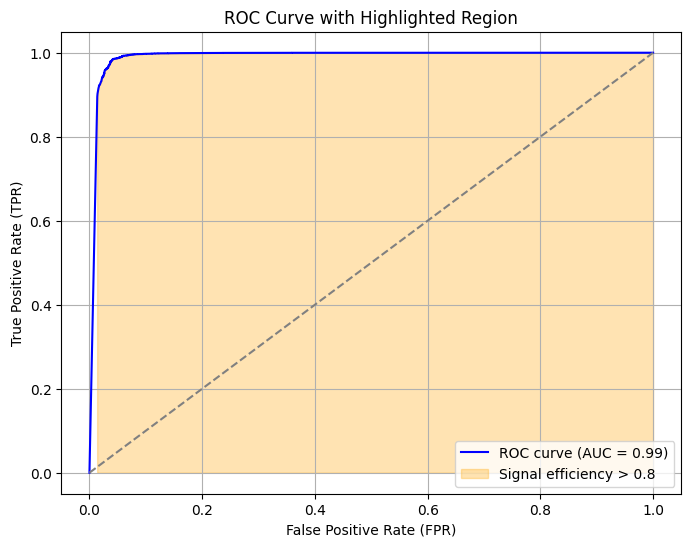

In [37]:
y_pred_probs = best_model.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_pred_probs, 0.8)

In [36]:
y_pred_probs = best_model.predict_proba(X_test)[:, 1]  # Assuming binary classification
partial_auc = calculate_partial_auc(y_test, y_pred_probs, tpr_min=0.8, tpr_max=1.0)
print(f"Partial AUC between TPR = 0.8 and TPR = 1: {partial_auc:.4f}")

Partial AUC between TPR = 0.8 and TPR = 1: 0.9844
